In [21]:
batch_size = 128
lr = 0.0002
train_epoch = 5
img_size = 64
in_channels = 100

# Load Libraries and Data

In [3]:
import cv2
import numpy as np
import glob
import sys
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt
import os, time

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
        plt.axis('off')
    plt.imshow(grid.numpy())

In [ ]:
if not os.path.exists('images'):
    ! wget -O ./faces.zip "https://github.com/landiinii/474PersonalProject/blob/main/faces.zip?raw=true"
    ! mkdir images
    ! unzip faces.zip -d images

faces_dataset = datasets.ImageFolder(root='./images',
                        transform=transforms.Compose([
                            transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
faces_loader = DataLoader(faces_dataset, batch_size=batch_size, pin_memory=True)

In [5]:
ix=99
x, _ = faces_dataset[ix]
# show_imgs(x)
x.size()

torch.Size([3, 64, 64])

# NN Models

In [6]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x


class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

# Training Loop

In [28]:
def train(train_loader, epochStart):    
    for epoch in range(epochStart, epochStart+train_epoch):
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        loop = tqdm(train_loader)
        for x_, _ in loop:

            curr_batch = x_.size()[0]
            y_real_ = torch.ones(curr_batch).cuda()
            y_fake_ = torch.zeros(curr_batch).cuda()

            D_optimizer.zero_grad() 

            x_ = x_.cuda()

            D_result = torch.squeeze(D(x_))
            D_real_loss = Loss(D_result, y_real_)

            z_vector = torch.randn(curr_batch, 100).view(-1,100,1,1).cuda()
            G_result = G(z_vector)

            D_G_result = torch.squeeze(D(G_result))
            D_fake_loss = Loss(D_G_result, y_fake_)

            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.item())




            G_optimizer.zero_grad()

            z_vector = torch.randn(curr_batch, in_channels).view(-1,in_channels,1,1).cuda()
            G_result = G(z_vector)

            D_G_result = torch.squeeze(D(G_result))
            G_train_loss = Loss(D_G_result, y_real_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.item())

            loop.set_description('epoch: {} -- loss_g: {:.4f} loss_d: {:.4f}'.format(epoch+1, G_train_loss.item(), D_train_loss.item()))

        # generate a fixed_z_ image and save
        x_gen = G(fixed_z_)
        collect_x_gen.append(x_gen.detach().clone())
        g_all_loss.append(torch.mean(torch.FloatTensor(G_losses)))
        d_all_loss.append(torch.mean(torch.FloatTensor(D_losses)))
        
        # print out statistics
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] - ptime: %.2f, loss_g: %.3f, loss_d: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, g_all_loss[-1], d_all_loss[-1]))

In [ ]:
# Binary Cross Entropy loss
Loss = nn.BCELoss()

G = Generator(batch_size)
D = Discriminator(batch_size)
G = G.cuda()
D = D.cuda()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
epoch = 0
g_all_loss = []
d_all_loss = []
collect_x_gen = []
fixed_z_ = torch.randn((4, in_channels)).view(-1, in_channels, 1, 1).cuda()   # fixed noise

if os.path.exists('GANModel.tar'):
    checkpoint = torch.load('GANModel.tar')
    G.load_state_dict(checkpoint['G'])
    D.load_state_dict(checkpoint['D'])
    G_optimizer.load_state_dict(checkpoint['G_optimizer'])
    D_optimizer.load_state_dict(checkpoint['D_optimizer'])
    epoch = checkpoint['epoch']
    g_all_loss = checkpoint['g_all_loss']
    d_all_loss = checkpoint['d_all_loss']
    collect_x_gen = checkpoint['collect_x_gen']
    fixed_z_ = checkpoint['fixed_z_']

train(faces_loader, epoch)
torch.save({
            'G': G.state_dict(),
            'D': D.state_dict(),
            'G_optimizer': G_optimizer.state_dict(),
            'D_optimizer': D_optimizer.state_dict(),
            'epoch': epoch,
            'g_all_loss': g_all_loss,
            'd_all_loss': d_all_loss,
            'collect_x_gen': collect_x_gen,
            'fixed_z_': fixed_z_
            }, 'GANModel.tar')

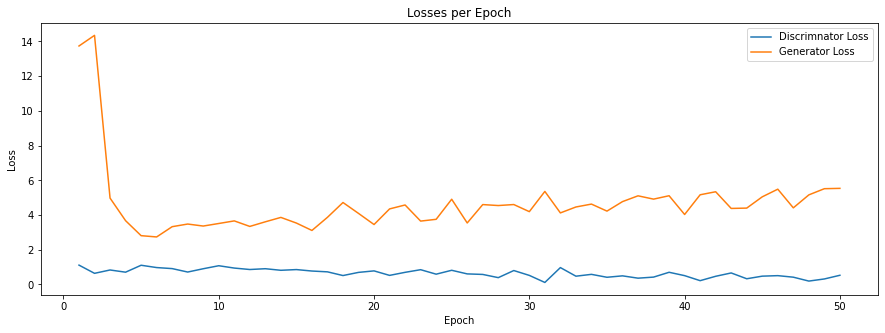

In [23]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(range(1, len(d_all_loss)+1), d_all_loss, label="Discrimnator Loss")
ax.plot(range(1, len(g_all_loss)+1), g_all_loss, label="Generator Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Losses per Epoch")
plt.legend()
plt.show()

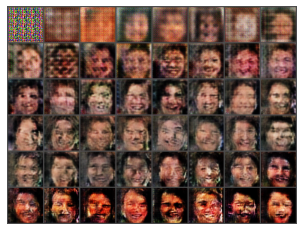

In [27]:
concat = collect_x_gen[0][:1]
for i in range(3, len(collect_x_gen)):
    concat = torch.cat((concat, collect_x_gen[i][:1]), 0)
show_imgs(concat)